# Finalise target variables

In [1]:
import xarray as xr
import pandas as pd

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


# Predictand - energy demand

In [3]:
aus_demand = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_20091201-20210130.csv",
    index_col=0,
    parse_dates=True
)

In [4]:
aus_demand = aus_demand.loc[slice("2010", "2020")]

Add a new NEM column

In [5]:
aus_demand["NEM"] = aus_demand.sum(axis=1)

In [6]:
aus_demand.head()

,NSW,QLD,SA,TAS,VIC,NEM
SETTLEMENTDATE,,,,,,
2010-01-01,187807.390,138161.770,28782.265,24126.010,116100.655,494978.090
2010-01-02,189870.310,144638.510,27521.545,23216.750,110599.670,495846.785
2010-01-03,182687.900,147167.875,30035.250,25759.430,118214.105,503864.560
2010-01-04,200653.775,150343.770,36857.625,27587.005,135119.005,550561.180
2010-01-05,214943.745,150493.095,38249.130,26478.305,136181.370,566345.645


NEM demand decreases over time. This looks to be consistent with data from OpenNEM, and possibly linked to the recent availability of rooftop solar. Without rooftop, this figure from OpenNEM would show a decrease. https://opennem.org.au/energy/nem/?range=all&interval=1y

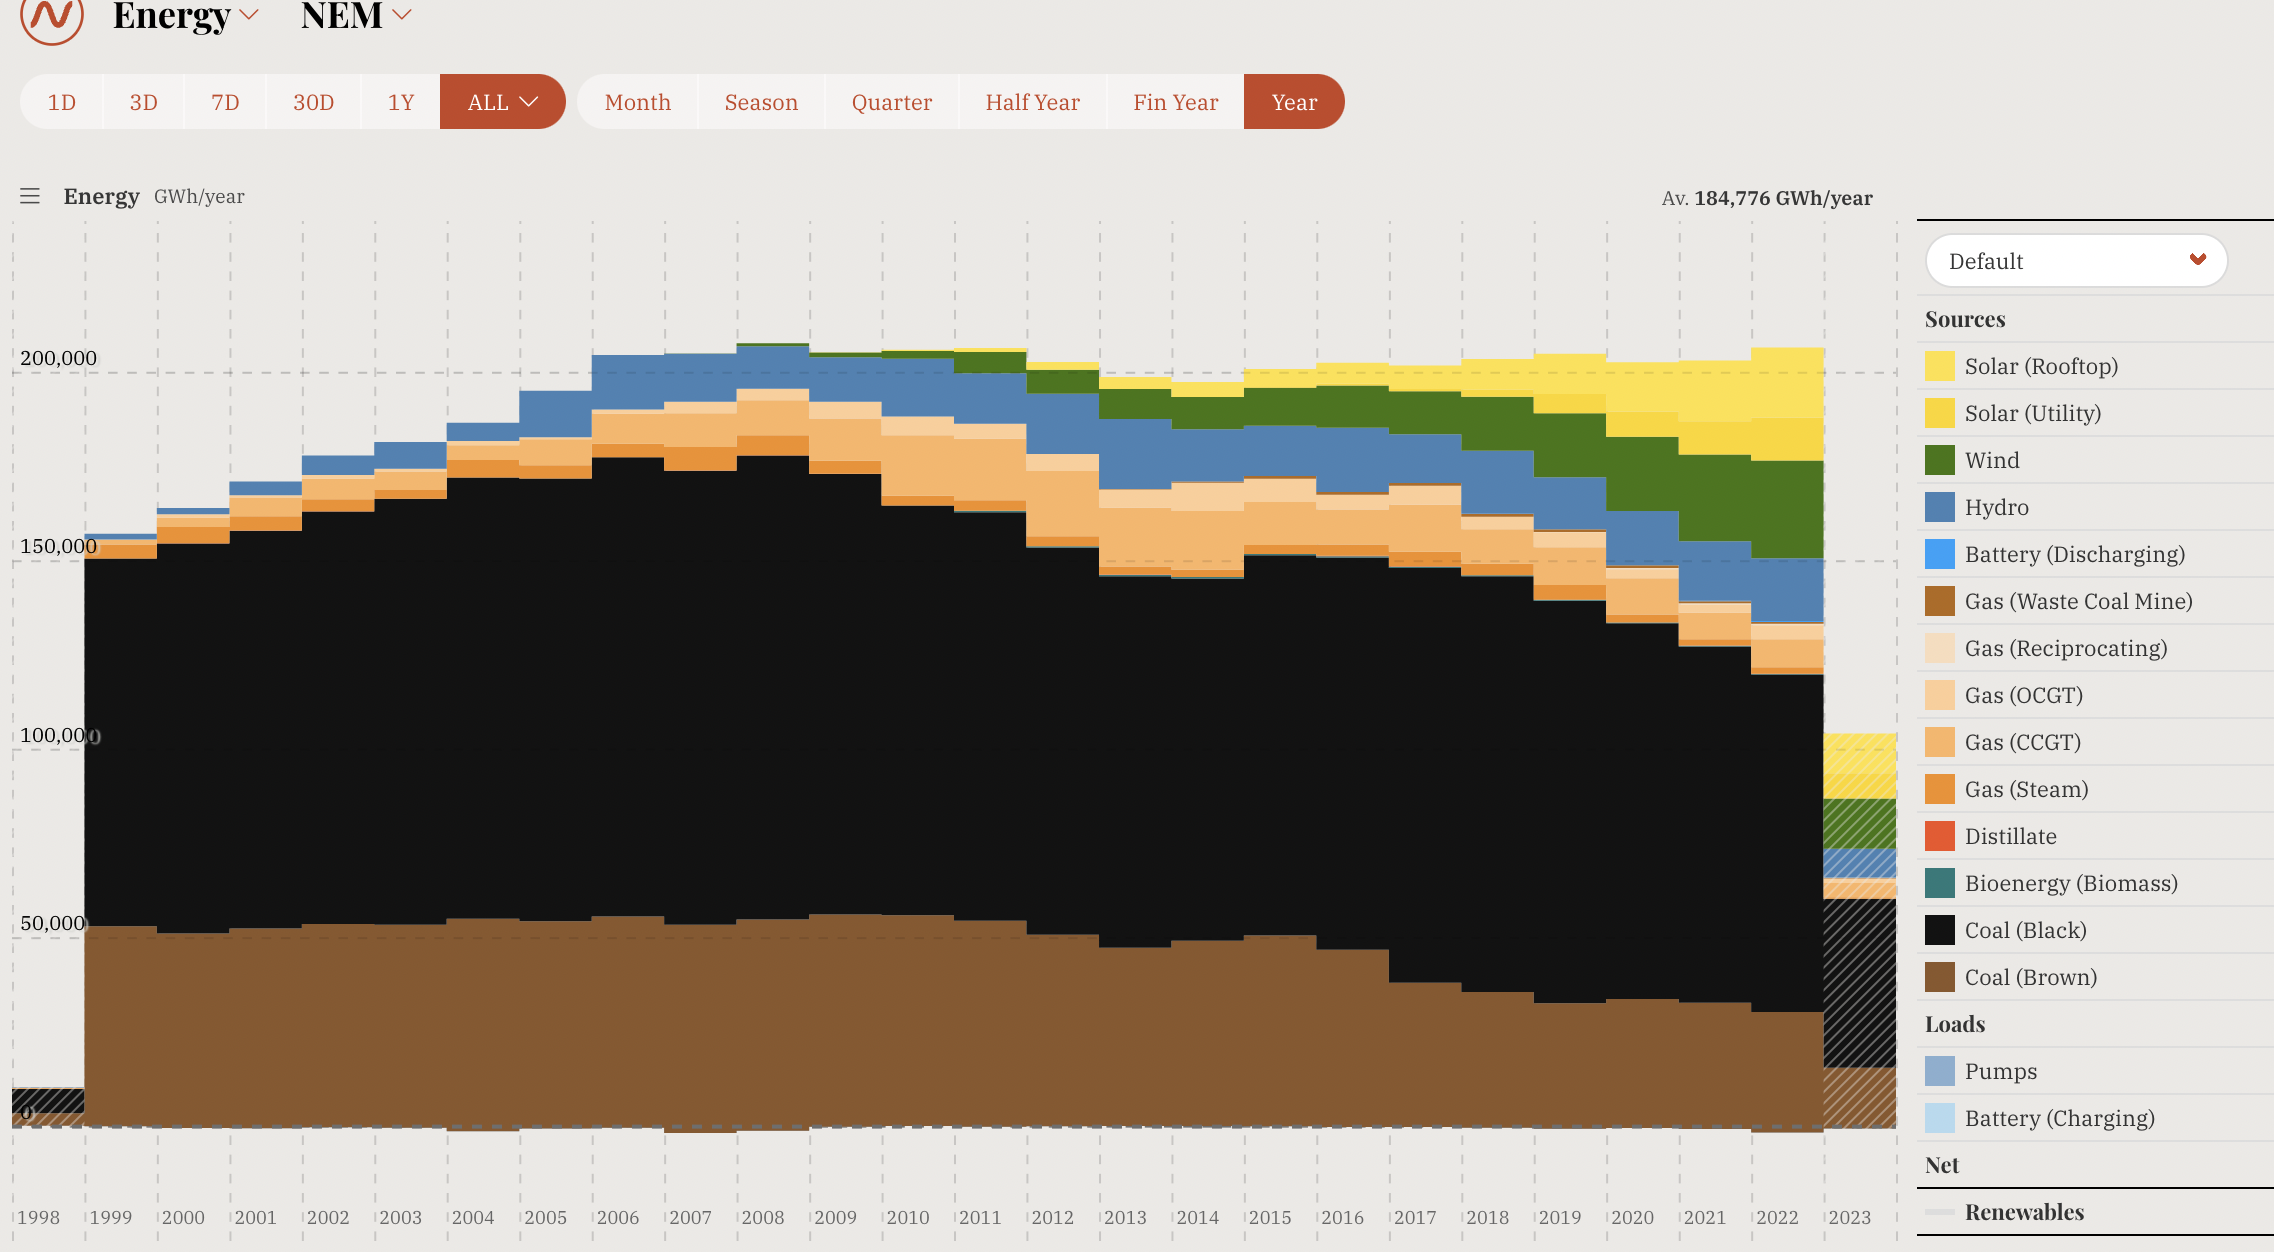

<AxesSubplot: xlabel='SETTLEMENTDATE'>

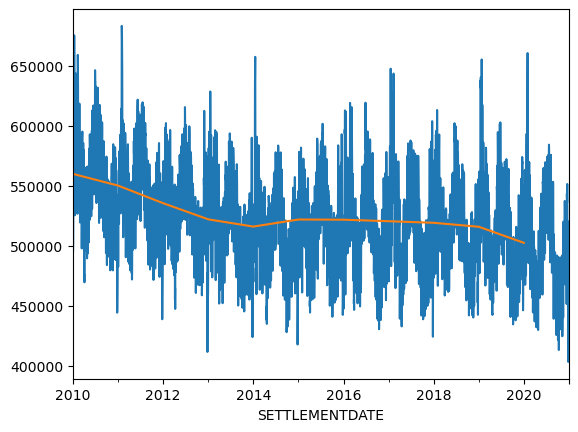

In [7]:
aus_demand["NEM"].plot()
aus_demand["NEM"].resample("Y").mean().plot()

Looks like we have the right ballpark. We're expecting ~200,000 GW/y, and we see ~1.9e8 / 1000 = 190,000 GW/y.

In [34]:
1.9e8 / 1000

190000.0

<AxesSubplot: xlabel='SETTLEMENTDATE'>

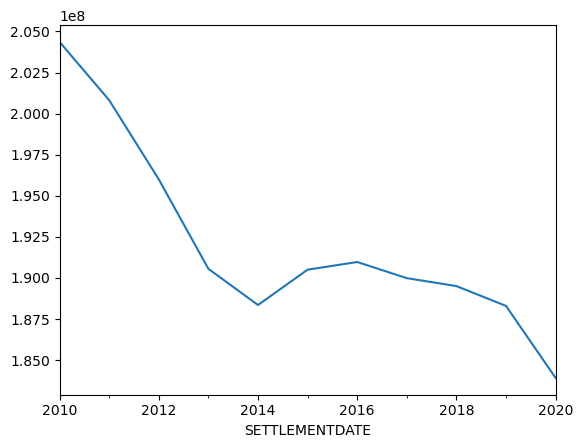

In [35]:
aus_demand["NEM"].resample("Y").sum().plot()

Detrend using `xarray`

In [36]:
aus_dem_da = xr.DataArray(
    aus_demand.transpose(),
    dims=["region", "time"],
    coords={"region": aus_demand.columns, "time": aus_demand.index.values}
)

In [37]:
aus_dem_dt = fn.detrend_dim(aus_dem_da, "time") + aus_dem_da.mean("time")

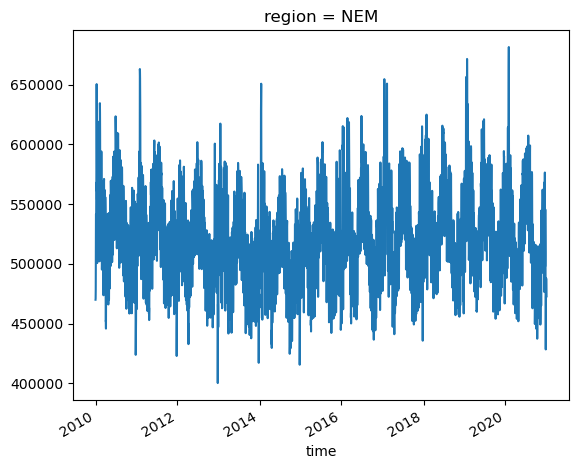

In [38]:
aus_dem_dt.sel(region="NEM").plot()

Write to netcdf

In [39]:
aus_dem_dt.to_dataset(name="demand_dt").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)

Alternatively, try seasonal-trend decomposition using LOESS (STL)

In [8]:
from statsmodels.tsa.seasonal import STL

In [9]:
aus_demand_less_trend = pd.DataFrame().reindex_like(aus_demand)

In [10]:
aus_demand_less_trend.columns

Index(['NSW', 'QLD', 'SA', 'TAS', 'VIC', 'NEM'], dtype='object')

In [58]:
for region in aus_demand_less_trend.columns:
    stl_model = STL(aus_demand[region], trend=365*3, robust=True)
    res = stl_model.fit()
    data_less_trend = res.observed - res.trend + aus_demand[region].mean()
    aus_demand_less_trend[region] = data_less_trend

In [59]:
aus_demand_less_trend.head()

,NSW,QLD,SA,TAS,VIC,NEM
SETTLEMENTDATE,,,,,,
2010-01-01,167621.888019,137290.809562,24879.692677,23165.831484,101059.475538,451465.097738
2010-01-02,169699.603911,143780.081355,23621.702581,22257.474681,95565.250461,452373.183829
2010-01-03,162531.991928,146321.967064,26138.138743,24801.059872,103186.446176,460430.342624
2010-01-04,180512.667072,149510.371669,32963.246163,26629.542060,120098.107679,507166.339096
2010-01-05,194817.439344,149672.195148,34357.484840,25521.751249,121167.234960,522990.173209


In [60]:
import matplotlib.pyplot as plt

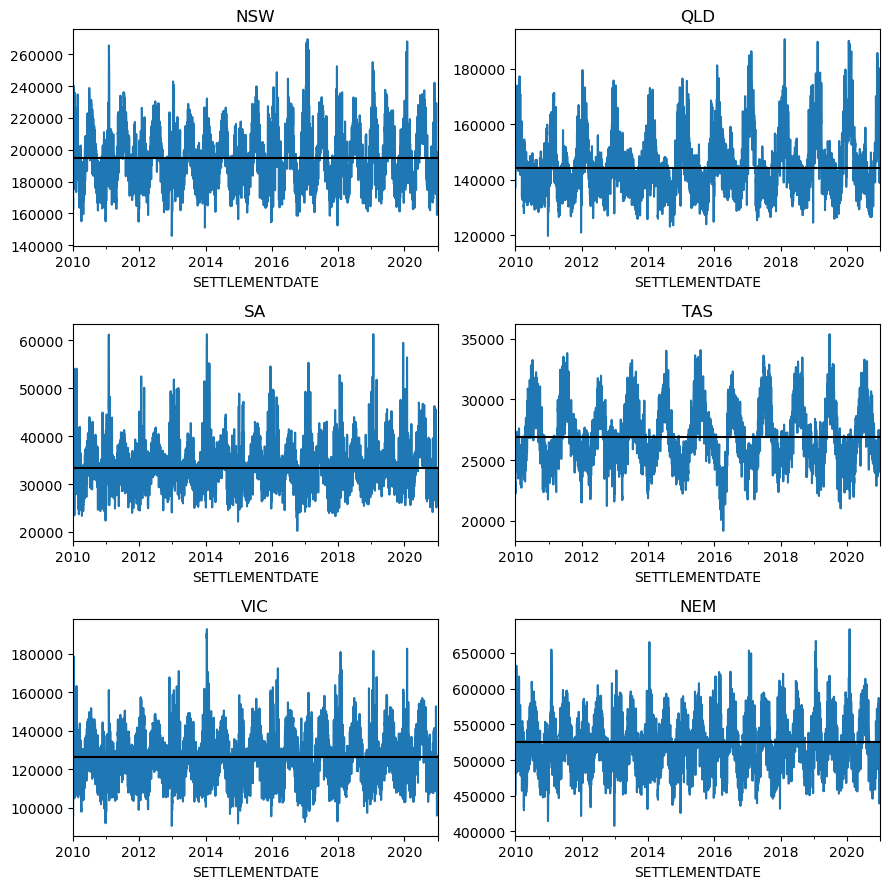

In [61]:
fig, ax = plt.subplots(3, 2, figsize=(9, 9))
for i, region in enumerate(aus_demand_less_trend.columns):
    aus_demand_less_trend[region].plot(ax=ax.flatten()[i])
    ax.flatten()[i].axhline(aus_demand[region].mean(), c="k")
    ax.flatten()[i].set_title(region)
plt.tight_layout()

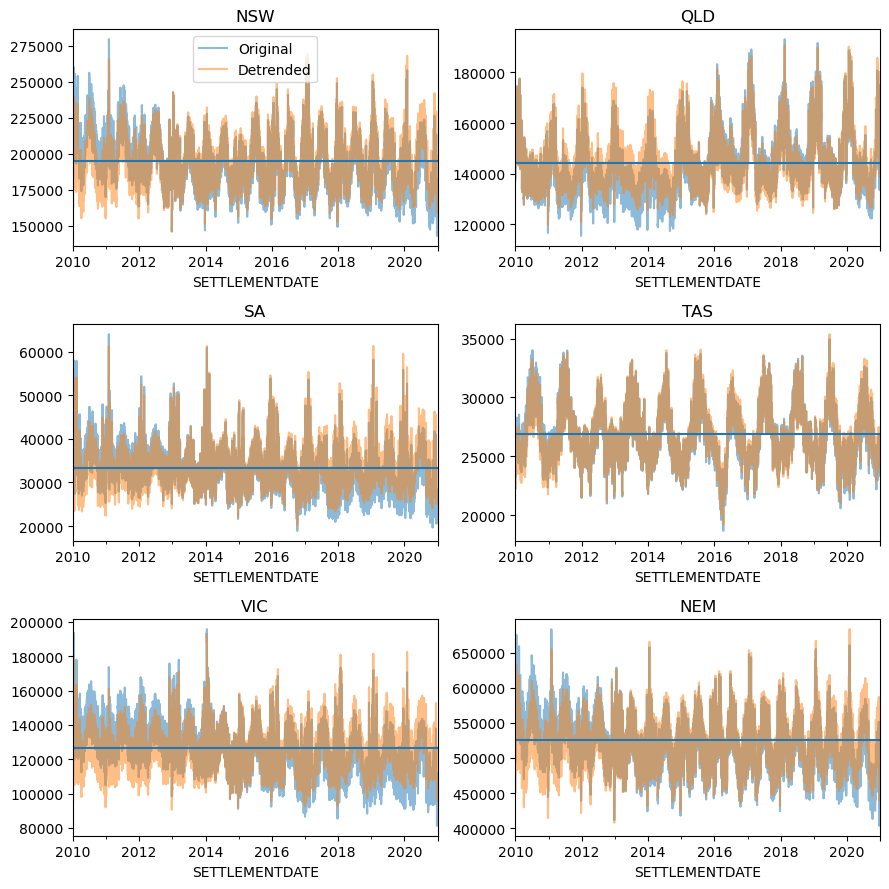

In [62]:
fig, ax = plt.subplots(3, 2, figsize=(9, 9))
for i, region in enumerate(aus_demand_less_trend.columns):
    aus_demand[region].plot(ax=ax.flatten()[i], alpha=0.5, label="Original")
    aus_demand_less_trend[region].plot(ax=ax.flatten()[i], alpha=0.5, label="Detrended")
    ax.flatten()[i].axhline(aus_demand[region].mean())
    ax.flatten()[i].set_title(region)
ax[0,0].legend()
plt.tight_layout()

In [63]:
aus_dem_less_trend_da = xr.DataArray(
    aus_demand_less_trend.transpose(),
    dims=["region", "time"],
    coords={"region": aus_demand_less_trend.columns, "time": aus_demand_less_trend.index.values}
)

In [64]:
aus_dem_less_trend_da.to_dataset(name="demand_stl").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc"
)

### Try different STL parameters

In [56]:
x = STL(aus_demand["QLD"], trend=365 * 3, robust=True).fit()

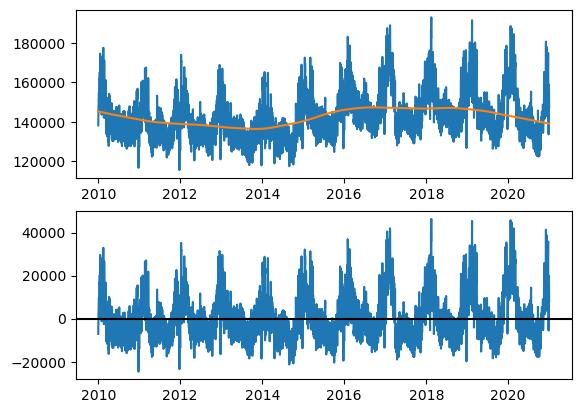

In [57]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(x.observed)
ax[0].plot(x.trend)
ax[1].plot(x.observed - x.trend)
ax[1].axhline(0, c="k")

### Europe demand

In [3]:
eu_demand = pd.read_csv(
    "/g/data/w42/dr6273/work/data/ENTSOE/EU_daily_demand_2010-2015.csv",
    index_col=0,
    parse_dates=True
)

In [4]:
# eu_demand = pd.read_csv(
#     "/g/data/w42/dr6273/work/data/ENTSOE/EU_daily_avg_demand_2006-2015.csv",
#     index_col=0,
#     parse_dates=True
# )

In [5]:
eu_dem_da = xr.DataArray(
    eu_demand.squeeze(),
    dims=["time"],
    coords={"time": eu_demand.index.values}
)

In [6]:
eu_dem_dt = fn.detrend_dim(eu_dem_da, "time") + eu_dem_da.mean("time")

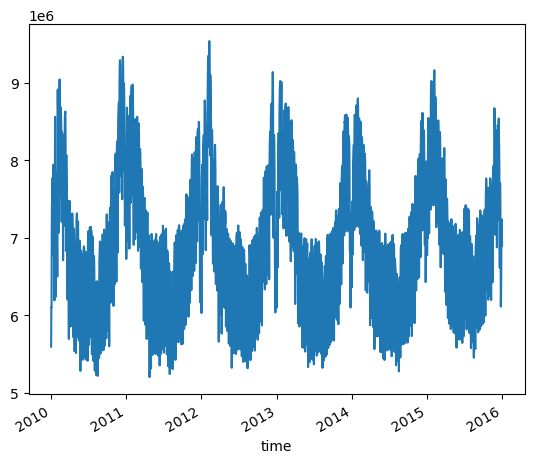

In [7]:
eu_dem_dt.plot()

In [8]:
eu_dem_dt.to_dataset(name="demand_dt").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/EU_daily_demand_2010-2020_detrended.nc"
)

In [31]:
# eu_dem_dt.to_dataset(name="demand_dt").to_netcdf(
#     "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/EU_daily_avg_demand_2006-2020_detrended.nc"
# )